In [1]:
# ===============================================================
# ✈️ Flight Fare Prediction
# ===============================================================
# Author: Aryan Najjari
# Description: Predicting flight ticket prices using 2 traditional ML models and GPT 4o Mini 
# ===============================================================

# ---------------------------
# 📦 Import Required Libraries
# ---------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 🔎 Step 1: Load and Explore Data

In [2]:
# Load the dataset
data = pd.read_csv("Flight Fare Data.csv")

# Display first 5 rows
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,3/22/25 1:10,2h 50m,non-stop,No info,3897
1,Air India,1/5/19,Kolkata,Banglore,CCU → IXR → BBI → BLR,5:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/6/19,Delhi,Cochin,DEL → LKO → BOM → COK,9:25,6/10/25 4:25,19h,2 stops,No info,13882
3,IndiGo,12/5/19,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,1/3/19,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# 🗒️ Interpretation:
This dataset contains flight details like airline, duration, stops, and price.
Before modeling, data will be cleaned and prepared for training. 

# 🧹 Step 2: Data Cleaning & Feature Engineering

In [3]:
# Clean and structure the dataset

# 1 Date modification

# Convert 'Date_of_Journey' to datetime safely, handling different formats
def extract_month(date_str):
    try:
        # Try to convert using pandas datetime parser
        return pd.to_datetime(date_str, dayfirst=True, errors='coerce').month
    except:
        return np.nan

# Apply the function to create a new 'Journey_Month' column
data['Journey_Month'] = data['Date_of_Journey'].apply(extract_month)

# Drop the original date column
data = data.drop(columns=['Date_of_Journey'], errors='ignore')

# Convert month number to month name
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

data['Journey_Month_Name'] = data['Journey_Month'].map(month_map)

#Drop the original column to avoid redundancy
data = data.drop(columns=['Journey_Month'], errors='ignore')

#-------------------------------------------------------------------------------

# 2 Time Modification

# Clean the 'Dep_Time' column to extract only the hour
def extract_hour(time_str):
    try:
        return int(str(time_str).split(':')[0])
    except:
        return np.nan

data['Dep_Hour'] = data['Dep_Time'].apply(extract_hour)

# Drop the original departure time column
data = data.drop(columns=['Dep_Time'], errors='ignore')

# Categorize departure hour into time of day
def get_time_of_day(hour):
    if pd.isna(hour):
        return np.nan
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 19:
        return 'Evening'
    else:
        return 'Night'

data['Dep_TimeOfDay'] = data['Dep_Hour'].apply(get_time_of_day)

#Drop the original column to avoid redundancy
data = data.drop(columns=['Dep_Hour'], errors='ignore')

#-------------------------------------------------------------------------------

# 3 Duration Modification

# Convert 'Duration' to total minutes
def duration_to_minutes(duration):
    try:
        duration = duration.strip().lower()
        hours = 0
        minutes = 0
        if 'h' in duration:
            hours = int(duration.split('h')[0].strip())
            if 'm' in duration:
                minutes = int(duration.split('h')[1].replace('m', '').strip() or 0)
        elif 'm' in duration:
            minutes = int(duration.replace('m', '').strip())
        total_minutes = hours * 60 + minutes
        return total_minutes
    except:
        return np.nan

data['Duration_mins'] = data['Duration'].apply(duration_to_minutes)

#Drop the original column to avoid redundancy
data = data.drop(columns=['Duration'], errors='ignore')

#-------------------------------------------------------------------------------

# 4 Total Stops Modifications

# Convert 'Total_Stops' to numbers
def stops_to_number(stops):
    try:
        stops = stops.strip().lower()
        if stops == 'non-stop':
            return 0
        else:
            return int(stops.split()[0])  # e.g., '2 stops' → 2
    except:
        return np.nan

data['Total_Stops_num'] = data['Total_Stops'].apply(stops_to_number)

# Drop the original column to avoid redundancy
data = data.drop(columns=['Total_Stops'], errors='ignore')

#-------------------------------------------------------------------------------

# 5 Remove unnecessary data

# Remove 'Arrival Time' and 'Route' which can make the data too complicated for training and has the risk of overfitting 
data = data.drop(columns=['Arrival_Time', 'Route'], errors='ignore')

#-------------------------------------------------------------------------------

# Display the data after processings

data.head()

,Airline,Source,Destination,Additional_Info,Price,Journey_Month_Name,Dep_TimeOfDay,Duration_mins,Total_Stops_num
0,IndiGo,Banglore,New Delhi,No info,3897,March,Night,170,0
1,Air India,Kolkata,Banglore,No info,7662,May,Morning,445,2
2,Jet Airways,Delhi,Cochin,No info,13882,June,Morning,1140,2
3,IndiGo,Kolkata,Banglore,No info,6218,May,Evening,325,1
4,IndiGo,Banglore,New Delhi,No info,13302,March,Evening,285,1


# 🗒️ Interpretation:
### Now the data is clean and well-structured.
#### 1. Instead of using the complete date of the journey, which could complicate the training process, only the month was considered to ensure a more organized training and evaluation.
#### 2. The same procedure was applied to the time of departure by categorizing it into morning, afternoon, evening, and night to logically evaluate the effect of the time of day on the price. Relying solely on numerical values could lead to significant misinterpretation.
#### 3. For consistency and better data organization, all flight durations have been converted to minutes.
#### 4. Text data in the “Total Stops” column were removed, leaving only numeric values to enable more effective categorization.
#### 5. The arrival time is considered unnecessary since the dataset already includes the departure time and flight duration. Additionally, the route feature is expected to complicate the model and hinder training due to the high variability in its textual values across data points.                                                                                                                                                   

# 🖥️ Step 3: Apply one hot encoding on the categorical data

In [4]:
# One-hot encode all categorical columns

categorical_cols = ['Dep_TimeOfDay', 'Airline', 'Source', 'Destination', 'Journey_Month_Name' , 'Additional_Info']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

#Display Data after encoding the categorical columns
data.head()

,Price,Duration_mins,Total_Stops_num,Dep_TimeOfDay_Evening,Dep_TimeOfDay_Morning,Dep_TimeOfDay_Night,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,...,Journey_Month_Name_March,Journey_Month_Name_May,Additional_Info_1 Short layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,3897,170,0,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,True,False
1,7662,445,2,False,True,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,13882,1140,2,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
3,6218,325,1,True,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,True,False
4,13302,285,1,True,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,True,False


# 🗒️ Interpretation:
After applying one-hot encoding, the data is ready for training and evaluation to determine the correlation between the features and the target variable (price).

# 👀 Step 4: Visualization

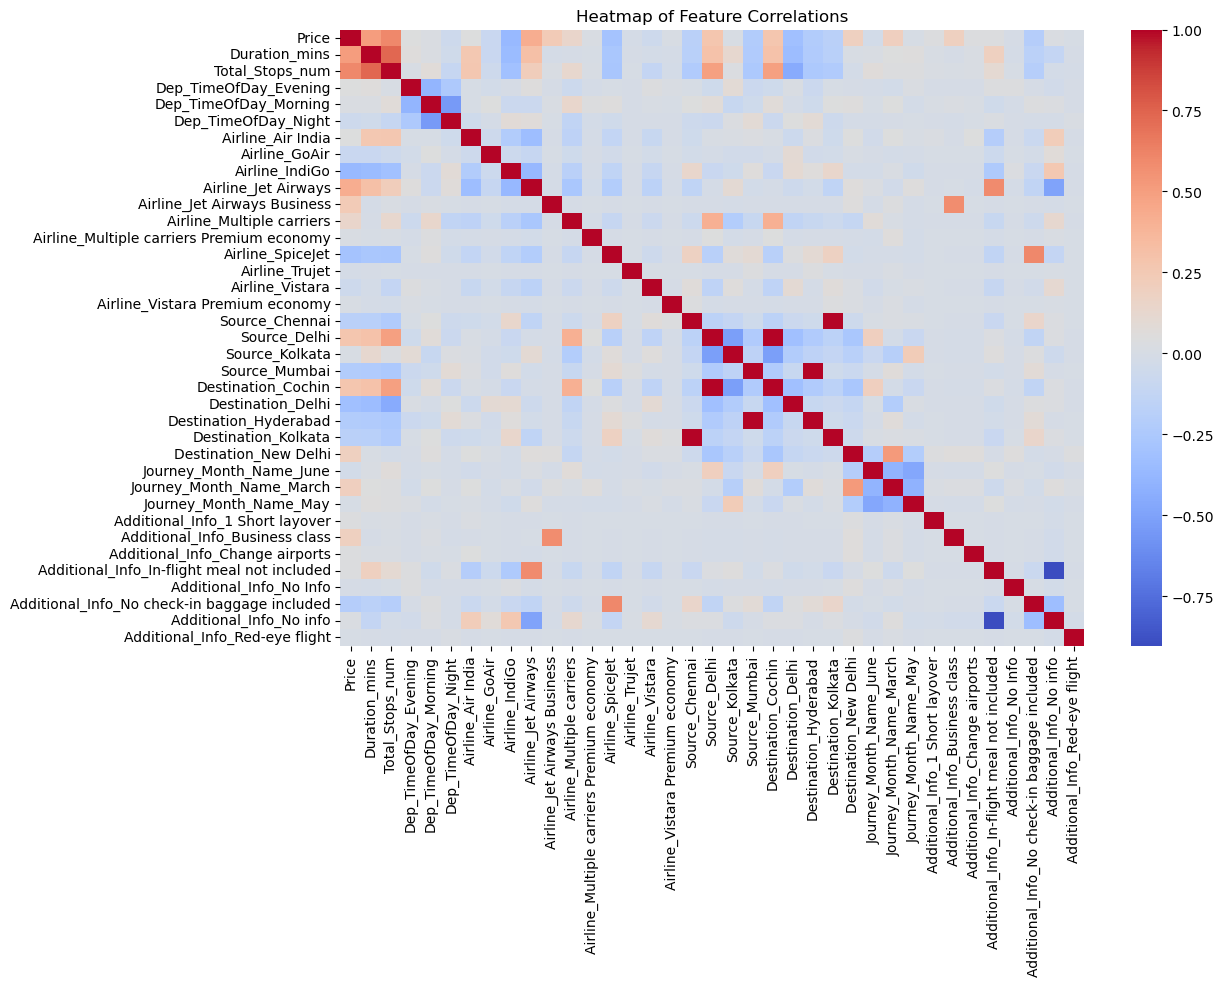

In [6]:
#Heatmap

plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)
plt.title("Heatmap of Feature Correlations")
plt.show()

In [7]:
# Calculate correlations with Price

correlation = data.corr()['Price'].sort_values(ascending=False)
print("Correlation of features with Price:\n")
print(correlation)

Correlation of features with Price:

Price                                           1.000000
Total_Stops_num                                 0.603755
Duration_mins                                   0.506678
Airline_Jet Airways                             0.422386
Destination_Cochin                              0.272468
Source_Delhi                                    0.272468
Airline_Jet Airways Business                    0.239616
Journey_Month_Name_March                        0.197514
Additional_Info_Business class                  0.193342
Destination_New Delhi                           0.192346
Airline_Multiple carriers                       0.138516
Airline_Air India                               0.045767
Dep_TimeOfDay_Evening                           0.044850
Additional_Info_1 Short layover                 0.041417
Additional_Info_In-flight meal not included     0.041119
Additional_Info_Change airports                 0.035910
Dep_TimeOfDay_Morning                           0.0

<Axes: ylabel='None'>

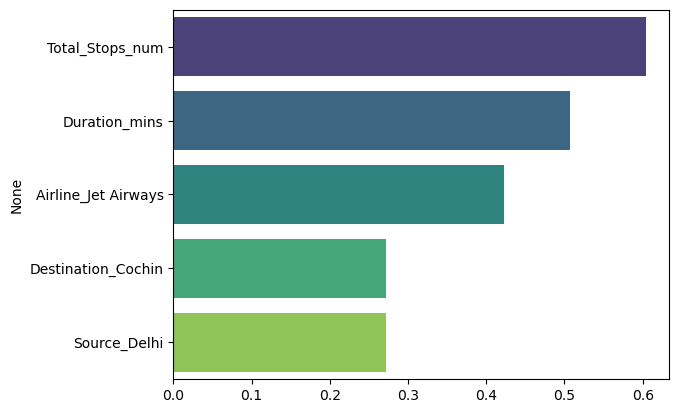

In [9]:
sns.barplot(
    x=top_features.values,
    y=top_features.index,
    hue=top_features.index,      
    palette="viridis",
    legend=False
)

# 🗒️ Interpretation:
Visualization helps in better understanding complex datasets (those with many features) and identifying the most influential features correlated with the target variable (Price). The visualization results indicate that **Flight Duration** and **Number of Stops** have the strongest positive impact on increasing the price. Additionally, flying with **Jet Airways**, traveling to **Cochin**, and departing from **Delhi** are also significant factors contributing to **higher** flight prices.

# 🚨 Step 5: Check the missing values in the dataset

In [10]:
# Check for missing (NaN) values in the dataset

# Quick overview — how many missing values per column
print("\n🔍 Missing values count per column:")
print(data.isnull().sum())

# Detailed check — show only columns that actually have missing values
print("\n⚠️ Columns with missing values only:")
print(data.isnull().sum()[data.isnull().sum() > 0])

# Actual rows containing missing values
print("\n📋 Rows with missing values:")
print(data[data.isnull().any(axis=1)])


🔍 Missing values count per column:
Price                                           0
Duration_mins                                   0
Total_Stops_num                                 0
Dep_TimeOfDay_Evening                           0
Dep_TimeOfDay_Morning                           0
Dep_TimeOfDay_Night                             0
Airline_Air India                               0
Airline_GoAir                                   0
Airline_IndiGo                                  0
Airline_Jet Airways                             0
Airline_Jet Airways Business                    0
Airline_Multiple carriers                       0
Airline_Multiple carriers Premium economy       0
Airline_SpiceJet                                0
Airline_Trujet                                  0
Airline_Vistara                                 0
Airline_Vistara Premium economy                 0
Source_Chennai                                  0
Source_Delhi                                    0
Source_Kolkata

# 🗒️ Interpretation:
#### The dataset contains no missing values. 😃

# ⌨️ Step 6: Data preparation for training 

In [11]:
# Define features (X) and target (y)
X = data.drop(columns=['Price'])
y = data['Price']

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🗒️ Interpretation:
It has been established that **Price** is the target variable in this dataset, while the remaining columns serve as features that influence increases or decreases in the price.

The dataset has been divided into training and testing subsets: the training set comprises 80% of the data and is used to train the model, while the remaining 20% forms the test set, which is used to evaluate the model’s performance after training.

# 🖊️ Step 7: Training and Evaluating (Linear Regression Model)

In [12]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make prediction on test data
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 1684.08
MSE: 5363530.52
RMSE: 2315.93
R2 Score: 0.70


# 🗒️ Interpretation:
#### **MAE:** Tells how far the model’s predictions are from the real values on average.

#### **MSE:** Shows how large the errors are overall, giving more weight to big mistakes.

#### **RMSE:** Similar to MSE but in the same unit as the target, showing the typical size of errors.

#### **R² Score:** Shows how well the model explains the changes in the target — the closer to 1, the better the model fits the data.

# 👀 Step 8: Visualization

Green (<10% error): 35.96%
Yellow (10–20% error): 28.42%
Red (>20% error): 35.61%


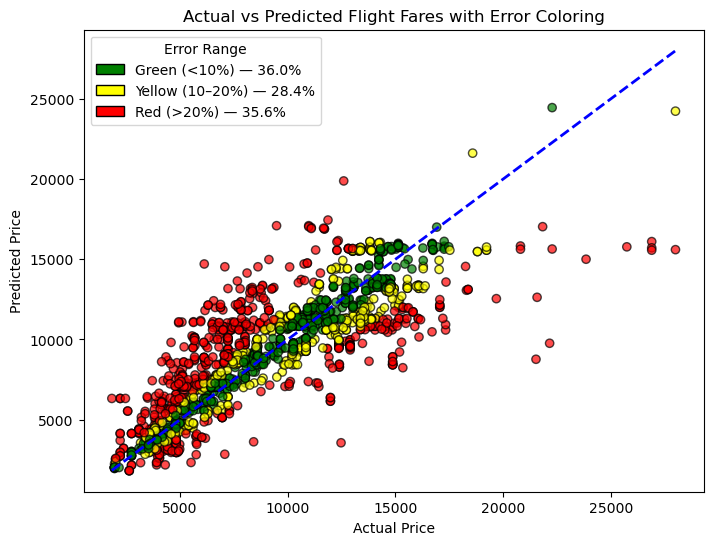

In [13]:
# Calculate percentage difference between actual and predicted prices
error_percent = np.abs(y_pred - y_test) / y_test * 100

# Categorize based on error range
color_labels = []
for err in error_percent:
    if err <= 10:
        color_labels.append('green')     # <10% difference
    elif err <= 20:
        color_labels.append('yellow')    # 10–20% difference
    else:
        color_labels.append('red')       # >20% difference

# Calculate and display percentages ---
total = len(color_labels)
green_pct = (color_labels.count('green') / total) * 100
yellow_pct = (color_labels.count('yellow') / total) * 100
red_pct = (color_labels.count('red') / total) * 100

print(f"Green (<10% error): {green_pct:.2f}%")
print(f"Yellow (10–20% error): {yellow_pct:.2f}%")
print(f"Red (>20% error): {red_pct:.2f}%")

# Plot actual vs predicted with color-coded errors
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, c=color_labels, alpha=0.7, edgecolors='k')

# Diagonal line for perfect prediction
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'b--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Flight Fares with Error Coloring")

# Legend showing the color meaning and percentages
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', edgecolor='k', label=f'Green (<10%) — {green_pct:.1f}%'),
    Patch(facecolor='yellow', edgecolor='k', label=f'Yellow (10–20%) — {yellow_pct:.1f}%'),
    Patch(facecolor='red', edgecolor='k', label=f'Red (>20%) — {red_pct:.1f}%')
]
plt.legend(handles=legend_elements, title="Error Range", loc="best")

plt.show()

# 🗒️ Interpretation:
Visualization of the results helps to see error range of the predicted results vs the actual results. This model is able to predict most of the datapoints with less than **20% difference**.

# ⚖️ Step 9: Apply Scaling on the numerical columns of the processed data

In [14]:
from sklearn.preprocessing import StandardScaler

# Make copies so the originals stay unchanged
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_cols = ['Duration_mins' , 'Total_Stops_num']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data, and transform both train and test
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make prediction on test data
y_pred = model.predict(X_test_scaled)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 1684.08
MSE: 5363530.52
RMSE: 2315.93
R2 Score: 0.70


# 🗒️ Interpretation:
Scaling does not affect the final results, which can be attributed to the presence of only two numerical columns in the entire dataset.

### Let's try another Machine Learning Model to see its results 

# 🟨 RandomForest 🟨 

# 🖊️ Step 1: Training and Evaluating (RandomForest)

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Create the model
rf = RandomForestRegressor(n_estimators=200, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest Results:\nMAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR2 Score: {r2:.3f}")

Random Forest Results:
MAE: 1060.11
MSE: 4024563.42
RMSE: 2006.13
R2 Score: 0.775


# 🗒️ Interpretation:
**RandomForest** shows **better** prediction ability on this dataset compared to **LinearRegression**.

# 👀 Step 2: Visualization

Green (<10% error): 64.80%
Yellow (10–20% error): 16.90%
Red (>20% error): 18.30%


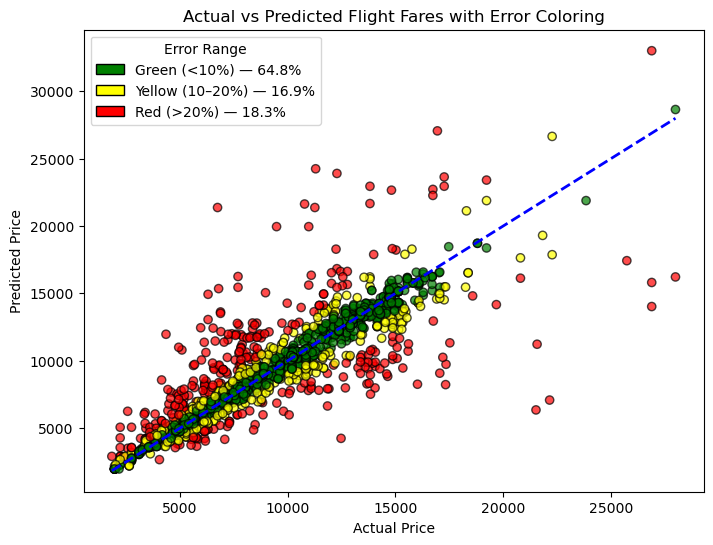

In [17]:
# Calculate percentage difference between actual and predicted prices
error_percent = np.abs(y_pred_rf - y_test) / y_test * 100

# Categorize based on error range
color_labels = []
for err in error_percent:
    if err <= 10:
        color_labels.append('green')     # <10% difference
    elif err <= 20:
        color_labels.append('yellow')    # 10–20% difference
    else:
        color_labels.append('red')       # >20% difference

# Calculate and display percentages ---
total = len(color_labels)
green_pct = (color_labels.count('green') / total) * 100
yellow_pct = (color_labels.count('yellow') / total) * 100
red_pct = (color_labels.count('red') / total) * 100

print(f"Green (<10% error): {green_pct:.2f}%")
print(f"Yellow (10–20% error): {yellow_pct:.2f}%")
print(f"Red (>20% error): {red_pct:.2f}%")

# Plot actual vs predicted with color-coded errors
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, c=color_labels, alpha=0.7, edgecolors='k')

# Diagonal line for perfect prediction
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'b--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Flight Fares with Error Coloring")

# Legend showing the color meaning and percentages
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', edgecolor='k', label=f'Green (<10%) — {green_pct:.1f}%'),
    Patch(facecolor='yellow', edgecolor='k', label=f'Yellow (10–20%) — {yellow_pct:.1f}%'),
    Patch(facecolor='red', edgecolor='k', label=f'Red (>20%) — {red_pct:.1f}%')
]
plt.legend(handles=legend_elements, title="Error Range", loc="best")

plt.show()

# 🗒️ Interpretation:
This visualization demonstrates a clear improvement in prediction performance using RandomForest compared to Linear Regression, as it accurately predicts **over 60%** of the data points with **less than a 10% error** and more than 80% of the data with less than a 20% error.

# ⚙️ Step 3: Examine the impact of hyperparameter tuning

In [19]:
#hyperparameter tuning on rf model

from sklearn.model_selection import RandomizedSearchCV

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Randomized Search (10-fold cross-validation)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,              # number of random combinations to try
    cv=5,                   # 5-fold cross-validation
    verbose=2,              # print progress
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

# Fit on training data
rf_random.fit(X_train, y_train)

# Best parameters
print("Best Parameters Found:")
print(rf_random.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters Found:
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}


# 🗒️ Interpretation:
The optimal parameters for achieving the most accurate model have been identified.

# 💡 Step 4: Using the parameters obtained from hyperparameter tuning 

In [20]:
# Use the best estimator
best_rf = rf_random.best_estimator_

# Predict
y_pred_best = best_rf.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_best)
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_best)

print(f"Tuned Random Forest Results:\nMAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR2 Score: {r2:.3f}")

Tuned Random Forest Results:
MAE: 1124.68
MSE: 3613562.53
RMSE: 1900.94
R2 Score: 0.798


# 🗒️ Interpretation:
The results of the metrics have improved. 👍

# 👀 Step 5: Visualization  

Green (<10% error): 59.24%
Yellow (10–20% error): 20.53%
Red (>20% error): 20.23%


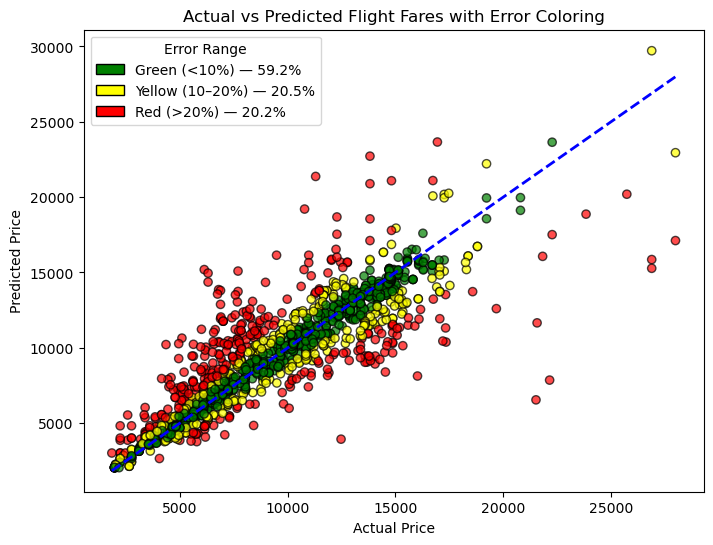

In [21]:
# Calculate percentage difference between actual and predicted prices
error_percent = np.abs(y_pred_best - y_test) / y_test * 100

# Categorize based on error range
color_labels = []
for err in error_percent:
    if err <= 10:
        color_labels.append('green')     # <10% difference
    elif err <= 20:
        color_labels.append('yellow')    # 10–20% difference
    else:
        color_labels.append('red')       # >20% difference

# Calculate and display percentages ---
total = len(color_labels)
green_pct = (color_labels.count('green') / total) * 100
yellow_pct = (color_labels.count('yellow') / total) * 100
red_pct = (color_labels.count('red') / total) * 100

print(f"Green (<10% error): {green_pct:.2f}%")
print(f"Yellow (10–20% error): {yellow_pct:.2f}%")
print(f"Red (>20% error): {red_pct:.2f}%")

# Plot actual vs predicted with color-coded errors
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, c=color_labels, alpha=0.7, edgecolors='k')

# Diagonal line for perfect prediction
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'b--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Flight Fares with Error Coloring")

# Legend showing the color meaning and percentages
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', edgecolor='k', label=f'Green (<10%) — {green_pct:.1f}%'),
    Patch(facecolor='yellow', edgecolor='k', label=f'Yellow (10–20%) — {yellow_pct:.1f}%'),
    Patch(facecolor='red', edgecolor='k', label=f'Red (>20%) — {red_pct:.1f}%')
]
plt.legend(handles=legend_elements, title="Error Range", loc="best")

plt.show()

# 🗒️ Interpretation:
Although the metrics indicate improved results, a lower percentage of green guesses and a higher percentage of red guesses are observed. This is primarily related to the quality of the red dots. While the **hyper-tuned model** contains more red dots, the **percentage difference** of red dots is **lower** compared to the red dots in the **non-hyper-tuned model**.

In the next stage, the ability of **GPT-40 Mini** to predict prices after **training with significantly less data** will be evaluated.

# 🟨 GPT 4O Mini 🟨

# Step 1: Preparing data for GPT
### 🔶 one-hot encoding is not required, but all other previous preprocessing steps will be performed again. 🔶

In [22]:
# Load the dataset
data_gpt = pd.read_csv("Flight Fare Data.csv")

# Display first 5 rows
data_gpt.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,3/22/25 1:10,2h 50m,non-stop,No info,3897
1,Air India,1/5/19,Kolkata,Banglore,CCU → IXR → BBI → BLR,5:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/6/19,Delhi,Cochin,DEL → LKO → BOM → COK,9:25,6/10/25 4:25,19h,2 stops,No info,13882
3,IndiGo,12/5/19,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,1/3/19,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [23]:
# Clean and structure the dataset

# 1 Date modification

# Convert 'Date_of_Journey' to datetime safely, handling different formats
def extract_month(date_str):
    try:
        # Try to convert using pandas datetime parser
        return pd.to_datetime(date_str, dayfirst=True, errors='coerce').month
    except:
        return np.nan

# Apply the function to create a new 'Journey_Month' column
data_gpt['Journey_Month'] = data_gpt['Date_of_Journey'].apply(extract_month)

# Drop the original date column
data_gpt = data_gpt.drop(columns=['Date_of_Journey'], errors='ignore')

# Convert month number to month name
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

data_gpt['Journey_Month_Name'] = data_gpt['Journey_Month'].map(month_map)

#Drop the original column to avoid redundancy
data_gpt = data_gpt.drop(columns=['Journey_Month'], errors='ignore')

#-------------------------------------------------------------------------------

# 2 Time Modification

# Clean the 'Dep_Time' column to extract only the hour
def extract_hour(time_str):
    try:
        return int(str(time_str).split(':')[0])
    except:
        return np.nan

data_gpt['Dep_Hour'] = data_gpt['Dep_Time'].apply(extract_hour)

# Drop the original departure time column
data_gpt = data_gpt.drop(columns=['Dep_Time'], errors='ignore')

# Categorize departure hour into time of day
def get_time_of_day(hour):
    if pd.isna(hour):
        return np.nan
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 19:
        return 'Evening'
    else:
        return 'Night'

data_gpt['Dep_TimeOfDay'] = data_gpt['Dep_Hour'].apply(get_time_of_day)

#Drop the original column to avoid redundancy
data_gpt = data_gpt.drop(columns=['Dep_Hour'], errors='ignore')

#-------------------------------------------------------------------------------

# 3 Duration Modification

# Convert 'Duration' to total minutes
def duration_to_minutes(duration):
    try:
        duration = duration.strip().lower()
        hours = 0
        minutes = 0
        if 'h' in duration:
            hours = int(duration.split('h')[0].strip())
            if 'm' in duration:
                minutes = int(duration.split('h')[1].replace('m', '').strip() or 0)
        elif 'm' in duration:
            minutes = int(duration.replace('m', '').strip())
        total_minutes = hours * 60 + minutes
        return total_minutes
    except:
        return np.nan

data_gpt['Duration_mins'] = data_gpt['Duration'].apply(duration_to_minutes)

#Drop the original column to avoid redundancy
data_gpt = data_gpt.drop(columns=['Duration'], errors='ignore')

#-------------------------------------------------------------------------------

# 4 Total Stops Modifications

# Convert 'Total_Stops' to numbers
def stops_to_number(stops):
    try:
        stops = stops.strip().lower()
        if stops == 'non-stop':
            return 0
        else:
            return int(stops.split()[0])  # e.g., '2 stops' → 2
    except:
        return np.nan

data_gpt['Total_Stops_num'] = data_gpt['Total_Stops'].apply(stops_to_number)

# Drop the original column to avoid redundancy
data_gpt = data_gpt.drop(columns=['Total_Stops'], errors='ignore')

#-------------------------------------------------------------------------------

# 5 Remove unnecessary data

# Remove 'Arrival Time' and 'Route' which can make the data too complicated for training and has the risk of overfitting 
data_gpt = data_gpt.drop(columns=['Arrival_Time', 'Route'], errors='ignore')

#-------------------------------------------------------------------------------

# Display the data after processings

data_gpt.head()

,Airline,Source,Destination,Additional_Info,Price,Journey_Month_Name,Dep_TimeOfDay,Duration_mins,Total_Stops_num
0,IndiGo,Banglore,New Delhi,No info,3897,March,Night,170,0
1,Air India,Kolkata,Banglore,No info,7662,May,Morning,445,2
2,Jet Airways,Delhi,Cochin,No info,13882,June,Morning,1140,2
3,IndiGo,Kolkata,Banglore,No info,6218,May,Evening,325,1
4,IndiGo,Banglore,New Delhi,No info,13302,March,Evening,285,1


# 🗒️ Interpretation:
## GPT-Ready-to-Use Dataset

# ⌨️ Step 2: Data preparation for training 

In [24]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import pandas as pd

# Load API key
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

train_df_gpt, test_df_gpt = train_test_split(data_gpt, test_size=0.2, random_state=42)

In [25]:
{"messages":[{"role":"system","content":"You are a helpful assistant that predicts flights' Price based on the other features."},
 {"role":"user","content":"Airline: Indigo, Source: Delhi, Destination: Cochin, Additional_Info: No info, Dep_TimeOfDay: Morning, Duration_mins: 285, Total_Stops_num: 1, Journey_Month_Name: March"},
 {"role":"assistant","content":"3897"}]}

{'messages': [{'role': 'system',
   'content': "You are a helpful assistant that predicts flights' Price based on the other features."},
  {'role': 'user',
   'content': 'Airline: Indigo, Source: Delhi, Destination: Cochin, Additional_Info: No info, Dep_TimeOfDay: Morning, Duration_mins: 285, Total_Stops_num: 1, Journey_Month_Name: March'},
  {'role': 'assistant', 'content': '3897'}]}

# 📄 Step 3: Creating json files

In [27]:
import json

def create_jsonl(df, filename):
    records = []
    for _, row in df.iterrows():
        user_prompt = (
            f"Airline: {row['Airline']}, "
            f"Source: {row['Source']}, "
            f"Destination: {row['Destination']}, "
            f"Departure Time: {row['Dep_TimeOfDay']}, "
            f"Duration: {row['Duration_mins']}, "
            f"Total Stops: {row['Total_Stops_num']}, "
            f"Additional Info: {row['Additional_Info']}, "
            f"Month: {row['Journey_Month_Name']}"
        )

        completion = str(row['Price'])

        record = {
            "messages": [
                {"role": "system", "content": "You are a helpful assistant that predicts flights' Price based on the other features."},
                {"role": "user", "content": user_prompt},
                {"role": "assistant", "content": completion}
            ]
        }
        records.append(record)

    # Save as JSONL
    with open(filename, "w") as f:
        for rec in records:
            json.dump(rec, f)
            f.write("\n")

# Create train and test files
create_jsonl(train_df_gpt, "train_gpt_finetune.jsonl")
create_jsonl(test_df_gpt, "test_gpt_eval.jsonl")

print("✅ JSONL files created successfully!")

✅ JSONL files created successfully!


# 🗒️ Interpretation:
Json files are created

# 📄 Step 4: Creating a JSON file with reduced data 
### For faster and more cost-effective training.

In [39]:
import json

# Read all records from the large JSONL file
with open("train_gpt_finetune.jsonl", "r") as f:
    records = [json.loads(line) for line in f]

# Select random 400 data
import random
sampled_records = random.sample(records, 400)

# Save them as a new smaller file
with open("train_gpt_400.jsonl", "w") as f:
    for rec in sampled_records:
        json.dump(rec, f)
        f.write("\n")

print("✅ Created 'train_gpt_400.jsonl' with 400 samples.")

✅ Created 'train_gpt_400.jsonl' with 400 samples.


# 💾 Step 5: Uploading the train data, fine tuning and monitoring the process

In [40]:
# Upload the 400-sample training file
train_file = client.files.create(
    file=open("train_gpt_400.jsonl", "rb"),
    purpose="fine-tune"
)

print("✅ Training file uploaded successfully!")
print("File ID:", train_file.id)

✅ Training file uploaded successfully!
File ID: file-7piZQfh4VVgagn2zyrCMcp


In [41]:
train_file_id = "file-7piZQfh4VVgagn2zyrCMcp"

# Fine-tuning GPT-4o-mini
job = client.fine_tuning.jobs.create(
    training_file=train_file_id,
    model="gpt-4o-mini-2024-07-18",
    suffix="flight-price-400"
)

print("🚀 Fine-tuning job started!")
print("Job ID:", job.id)

🚀 Fine-tuning job started!
Job ID: ftjob-t9QgGGekg2e9emWKJjOF8OXQ


In [42]:
import time

job_id = "ftjob-t9QgGGekg2e9emWKJjOF8OXQ"

while True:
    status = client.fine_tuning.jobs.retrieve(job_id)
    print(f"Status: {status.status}")
    if status.status in ["succeeded", "failed", "cancelled"]:
        print("✅ Fine-tuning finished!")
        print(f"Fine-tuned model: {status.fine_tuned_model}")
        break
    time.sleep(30)  # check every 30 seconds

Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Stat

# 🔍 Step 6: Evaluating the fine tuned model

In [43]:
model_name = "ft:gpt-4o-mini-2024-07-18:personal:flight-price-400:CQ3WW2pF"

# Load test data
test_records = []
with open("test_gpt_eval.jsonl", "r") as f:
    for line in f:
        test_records.append(json.loads(line))

# Run predictions in batches of 10
batch_size = 10
predicted_prices = []
actual_prices = []

for i in range(0, len(test_records), batch_size):
    batch = test_records[i:i+batch_size]
    
    for rec in batch:
        user_prompt = rec["messages"][1]["content"]
        actual_price = float(rec["messages"][2]["content"])
        actual_prices.append(actual_price)
        
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a helpful assistant that predicts flight prices based on flight features."},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0
        )
        
        # Try to extract numeric prediction safely
        try:
            pred_price = float(response.choices[0].message.content.strip().split()[0])
        except:
            pred_price = np.nan
        predicted_prices.append(pred_price)

print("✅ Predictions completed!")

✅ Predictions completed!


In [44]:
# Convert to NumPy arrays
y_true = np.array(actual_prices)
y_pred = np.array(predicted_prices)

# Remove NaN predictions if any
mask = ~np.isnan(y_pred)
y_true = y_true[mask]
y_pred = y_pred[mask]

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\n📈 Fine-Tuned Model Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.2f}")


📈 Fine-Tuned Model Evaluation:
MAE:  1671.45
MSE:  6693850.15
RMSE: 2587.25
R2:   0.63


# 🗒️ Interpretation:
Although the GPT-4o Mini demonstrates lower predictive accuracy based on the metrics, it is important to note that this evaluation was conducted using only **400 training data points**, whereas traditional ML methods were trained on more than 8,000 data points.

# 👀 Step 7: Visualization 

Green (<10% error): 41.93%
Yellow (10–20% error): 22.69%
Red (>20% error): 35.38%


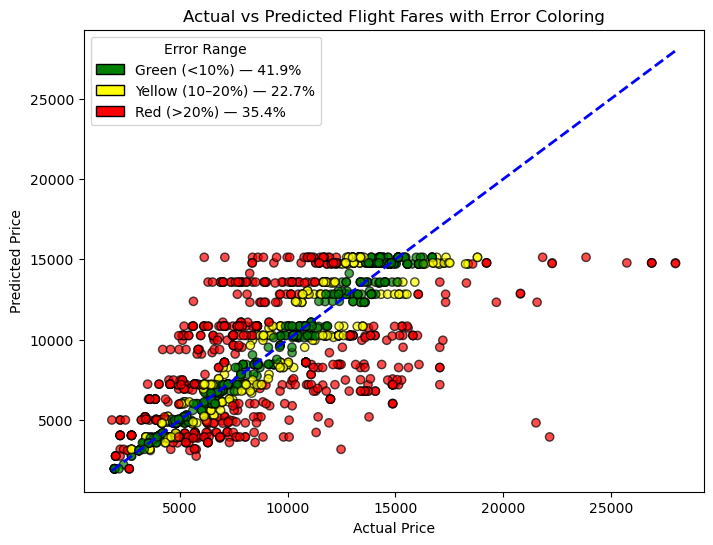

In [45]:
# Calculate percentage difference between actual and predicted prices
error_percent = np.abs(y_pred - y_true) / y_true * 100

# Categorize based on error range
color_labels = []
for err in error_percent:
    if err <= 10:
        color_labels.append('green')     # <10% difference
    elif err <= 20:
        color_labels.append('yellow')    # 10–20% difference
    else:
        color_labels.append('red')       # >20% difference

# Calculate and display percentages ---
total = len(color_labels)
green_pct = (color_labels.count('green') / total) * 100
yellow_pct = (color_labels.count('yellow') / total) * 100
red_pct = (color_labels.count('red') / total) * 100

print(f"Green (<10% error): {green_pct:.2f}%")
print(f"Yellow (10–20% error): {yellow_pct:.2f}%")
print(f"Red (>20% error): {red_pct:.2f}%")

# Plot actual vs predicted with color-coded errors
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, c=color_labels, alpha=0.7, edgecolors='k')

# Diagonal line for perfect prediction
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'b--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Flight Fares with Error Coloring")

# Legend showing the color meaning and percentages
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', edgecolor='k', label=f'Green (<10%) — {green_pct:.1f}%'),
    Patch(facecolor='yellow', edgecolor='k', label=f'Yellow (10–20%) — {yellow_pct:.1f}%'),
    Patch(facecolor='red', edgecolor='k', label=f'Red (>20%) — {red_pct:.1f}%')
]
plt.legend(handles=legend_elements, title="Error Range", loc="best")

plt.show()

# 🗒️ Interpretation:
## Prediction accuracy:

Traditional ML has lower errors (MAE & RMSE) → it predicts flight prices more accurately.

Fine-tuned GPT-4o-mini is less accurate, likely because it was trained on only 400 samples, which is very small for a regression task.

Explained variance (R²):

Traditional ML explains ~80% of the variance in prices.

GPT-4o-mini explains ~63% → it captures the trend but misses more details.

Data efficiency:

GPT-4o-mini can learn some patterns from a small dataset, but regression tasks benefit heavily from larger structured data.

Traditional ML models trained on all 8,000 rows clearly outperform a small GPT fine-tuned model.

### Use case insight:

Fine-tuned LLMs like GPT are better for natural language reasoning or mixed feature types, but for tabular regression with numeric features, classical ML is usually more accurate and cost-effective.